# Bootstrap Filter

In [1]:
import numpy as np
import math
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import copy
%matplotlib inline 

## multistate MAP particle filter
Idea:
* object with paricle filter as states
* state with highest probability gets the data point
* update just this state
* this is just as the difital filter from the analytical algorithm

* the assignement of the data point can maybe done bayes and not MAP later

In [23]:
class A():
    def __init__(self,s):
        self.s = s
        print 'Hello I am A'
        
class Factory():
    def __init__(self,cls):
        self.cls = cls
    def getInstance(self):
        return self.cls("aaa")
f = Factory(A)
a = f.getInstance()
print a.s

Hello I am A
aaa


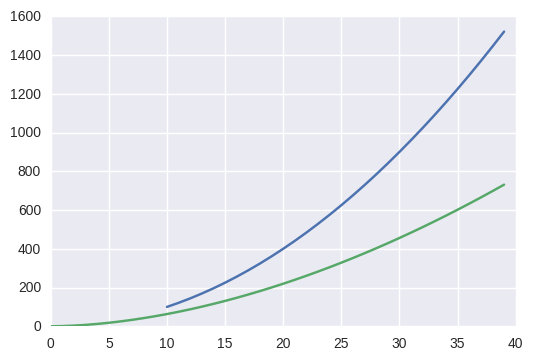

In [49]:
x1 = range(10,40)
y1 = [i**2 for i in x1]
x2 = range(40)
y2 = [i**(1.8) for i in x2]

plt.plot(x1,y1)
plt.plot(x2,y2)
plt.show()

In [78]:
def TestData(mean=[2,-4], var=[1,1], n=20, skips=3):
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%2],var[i%2],n))
    return data

def runParticleFilter():
    #create data
    data = TestData()
    particles = []
    z = []
    mean = []
    var = []
    bs = MultiStateMAPBootstrapFilter(BootstrapFilter)
    for i, d in enumerate(data):
        l, m, v= bs.update(d)        
        z.append(list(l))
        mean.append(list(m))
        #var.append((list(v),i))
    #add zeros to the front of z values
            
    #printParticleFilter(data, particles, mean)
    #print z, mean0, mean1
    return data, z, mean

In [83]:
def plotMultiStateParticle(data, z, m ):
    
    states = 0
    zData = []
    meanData = []
    varData = []
    for t,z_t in enumerate(z):
        if len(z_t)>states:
            states += 1
            zData.append(([],range(t,len(data))))
            meanData.append(([],range(t,len(data))))
            varData.append(([],range(t,len(data))))
        for i,z_t_i in enumerate(z_t):
            zData[i][0].append(z_t_i)
            #print m[t]
            meanData[i][0].append(m[t][i])
    #print zData[0]
    fig, ax1 = plt.subplots()
    ax1.set_ylim([-0.2,1.2])
    for z in zData: 
        ax1.plot(z[1], z[0])
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('probability', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(range(0,len(data)), data, 'r.')
    ax2.set_ylabel('data values', color='r')
    ax2.tick_params('y', colors='r')
    plt.title("Probability for the two states at each datum")
    plt.show()
    
    for m in meanData:
        plt.plot(m[1], m[0])
    plt.scatter(range(0,len(data)),data, color='red')
    plt.title('mean of the two states')
    plt.show()

In [94]:
class MultiStateMAPBootstrapFilter(object):
    beta = 0.001
    def __init__(self, cls, states=0):
        self.cls = cls
        self.bsf = []
        self.data = []
        for s in range(states):
            p = np.random.normal(np.random.uniform(low=-5, high=5), size=200, var=4)
            self.bsf.append(self.cls(particles=p))
        
    def update(self,_x):
        if len(self.bsf)<1:
            self.addState(_x)
        likelihood = []
        for f in self.bsf:
            l = scipy.stats.norm(f.mean, f.var).pdf(_x)
            likelihood.append(l[0])

        indexMaxL = likelihood.index(max(likelihood))
        if(max(likelihood)<self.beta):#this could work better with outlier detection
            indexMaxL = self.addState(_x)
        self.bsf[indexMaxL].importantSampling(_x)
        mean = []
        var = []
        for f in self.bsf:
            mean.append(f.mean[-1])
            var.append(f.var[-1])
        return [l/max(likelihood) for l in likelihood], mean, var
    
    def addState(self, _x):
        print 'adding a new state at: '+str(_x)
        p = np.random.normal(_x, size=200)
        self.bsf.append(self.cls(particles=p))
        return len(self.bsf)-1

In [95]:
d, z, m = runParticleFilter()

adding a new state at: -3.33628747808
resampling
resampling
resampling
adding a new state at: 1.16696919481
resampling
resampling
adding a new state at: 5.08680125483


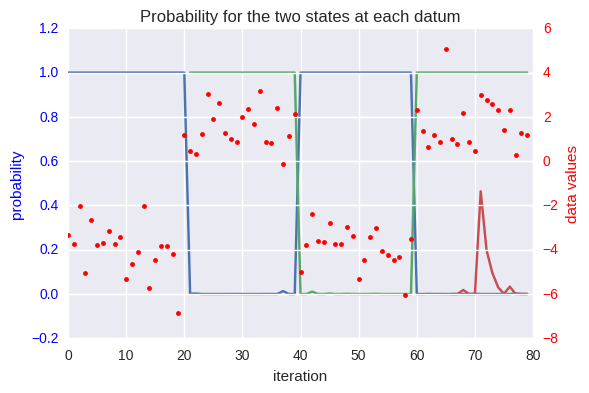

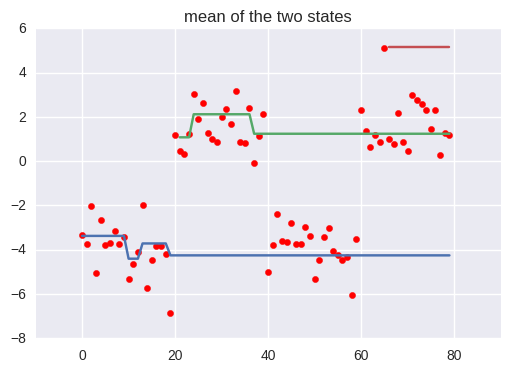

In [96]:
plotMultiStateParticle(d,z,m)

## Particle Filter
The particles are like datapoints

In [12]:
class BootstrapFilter(object):
    
    def __init__(self, d=1, likelihood=(0,1), prior=(-5,5), N=200, \
                 noise = 0.1, particles=None):
        self.dimension = d
        self.prior = prior
        self.noise = noise
        self.likelihood = likelihood
        
        if particles is not None:
            self.particles = particles
            self.weights = np.ones(len(self.particles))
        else:           
            #particles are drawn form a uniform square
            self.particles = np.random.uniform(low=prior[0], high=prior[1],\
                                               size=(N,d))
            self.weights = np.ones(N)
        self.mean = [np.mean(self.particles)]
        self.var = [np.var(self.particles)]
        
    def importantSampling(self, datum, a=1):
        for i, p in enumerate(self.particles):
            self.particles[i] = self.markovTransition(p)
            #weightParticle
            self.weights[i] = scipy.stats.norm(datum, \
                    self.likelihood[1]).pdf(self.particles[i]) * a      
        #normalise weights
        weightSum = np.sum(self.weights)
        self.weights = self.weights/weightSum
        #mean = np.average(self.particles, weights=self.weights, axis=0)[0]       
        if 1. / np.sum(np.square(self.weights)) < len(self.weights) / 2:            
            self.multinomialResampling()
            print 'resampling'
        else:
            #print 'no resampling'
            pass
        mean = np.mean(self.particles)
        self.mean.append(mean)
        self.var.append(np.var(self.particles)) 
        return self.particles, self.weights
        
    def markovTransition(self, p):
        return p #+ np.random.normal(0,self.noise)
        
    def multinomialResampling(self):
        N = len(self.weights)
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1
        uniform = np.random.uniform(size=N)
        indexes = np.searchsorted(cumsum, uniform)
        # resample according to indexes
        self.particles = self.particles[indexes]
        self.weights.fill(1.0 / N)
        
        

In [3]:
def printParticleFilter(data, particles, mean, weights=None):
    alpha = 0.02
    for x, y in zip(range(len(data)), particles):
        plt.scatter([x] * len(y), y, color='g', alpha=alpha)
    plt.plot(mean, color='g')
    plt.scatter(range(0,len(data)),data, color='red')
    plt.title('mean of the particle filter with particles')
    plt.show()
    
    
    
    var = np.array([np.var(x) for x in particles])
    mean = np.array(mean)
    print type(var), type(mean)
    upperBound = mean + var
    lowerBound = mean - var
    #plt.plot(upperBound, color='g', alpha=0.7)
    #plt.plot(lowerBound, color='g', alpha=0.7)
    plt.fill_between(range(len(data)), upperBound, lowerBound, color='g', alpha=0.3)
    plt.plot(mean, color='g')
    plt.scatter(range(len(data)),data, color='red')
    plt.title('mean of the particle filter with bounds')
    plt.show()

In [4]:
def TestData(mean=[4,-4], var=[1,1], n=20, skips=3):
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%2],var[i%2],n))
    return data

def runParticleFilter():
    #create data
    data = TestData()
    particles = []
    weights = []
    #feed data to particle Filter
    bs = BootstrapFilter(1,N=2000)
    for i, d in enumerate(data):
        p, w = bs.importantSampling(d)
        particles.append(p.copy())
        weights.append(w.copy())
    mean = bs.mean
    printParticleFilter(data, particles, mean)
    return data, particles, mean

In [ ]:
d,p,m = runParticleFilter()

resampling
resampling
resampling
resampling
resampling
resampling
resampling


## Multi Particle Filter for multi states

In [196]:
type(scipy.stats.norm(3, 2).pdf(5))

numpy.float64

In [250]:
class MultiBootstrapFilter(object):
    
    def __init__(self, states, N=500):
        self.bsf = []
        self.data = []
        for i in range(states):
            p = np.random.normal(np.random.uniform(low=-5, high=5), size=500)
            self.bsf.append(BootstrapFilter(1, particles=p))     
        
    def update(self, _x):
        stepData = []
        assigment = np.zeros(len(self.bsf))
        print _x
        for i,f in enumerate(self.bsf):
            assigment[i] = scipy.stats.norm(f.mean[-1], f.var[-1]).pdf(_x)
            print 'mean', f.mean[-1]
        assigment = assigment / np.sum(assigment)
        for f,a in zip(self.bsf, assigment):
            print 'assigment', a
            stepData.append(f.importantSampling(_x, a=a))
        print ""
        return stepData

In [258]:
def runMBSF():
    #create data
    data = TestData(n=5, skips=1)
    particles0 = []
    particles1 = []
    mbsf = MultiBootstrapFilter(2)    
    #feed data to particle Filter
    for d in data:
        stepData = mbsf.update(d)
        
        particles0.append(stepData[0][0].copy())
        particles1.append(stepData[1][0].copy())
    mean0 = mbsf.bsf[0].mean
    mean1 = mbsf.bsf[1].mean
    #printParticleFilter(data, particles, mean)
    return data, particles0, particles1, mean0, mean1

resampling seems not to work? maybe nuerical issues. maybe the wrong filter resamples?

There are two problems:
* the assigment is to narrow. This means that the values are to strong, too much ones and zeros. Probably the variance after resampling is too low.
* The assigment does not do the thing i want right now. I use it to weight all particle in a filter. But all particles are weighted the same. So the endresult is canceled out by normalising. Somehow i need to weight all particles at once. This way the assigment would do want i wanted, maybe.

In [259]:
d,p0,p1,m0,m1 = runMBSF()

-4.68127874679
mean 4.67979226655
mean 0.359379457967
assigment 8.72721375566e-14
resampling
assigment 1.0
resampling

-3.60933724285
mean 1.48809858121
mean -2.31356252478
assigment 0.0


/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide


assigment 1.0

-4.76488259935
mean 1.48759857584
mean -2.31043523308
assigment 0.0
assigment 1.0

-4.36757802537
mean 1.48650050199
mean -2.32095910221
assigment 0.0
assigment 1.0

-3.67447101092
mean 1.48634596141
mean -2.30775608653
assigment 0.0
assigment 1.0

4.87183558339
mean 1.48537862319
mean -2.30895447113
assigment 0.0
assigment 1.0
resampling

2.22789934294
mean 1.49012802112
mean -0.585471935707
assigment 1.0
assigment 0.0

3.90521044468
mean 1.48550870041
mean -0.580579326033
assigment 1.0
assigment 0.0

4.78780184408
mean 1.48456502437
mean -0.574413186162
assigment 1.0
resampling
assigment 0.0

4.78855403903
mean 1.93767540075
mean -0.572721419451
assigment 1.0
resampling
assigment 0.0



In [204]:
def plotMBFS2(d,p0,p1,m0,m1):
    plt.scatter(range(len(d)), d, color='r')
    plt.plot(m0)
    plt.plot(m1)

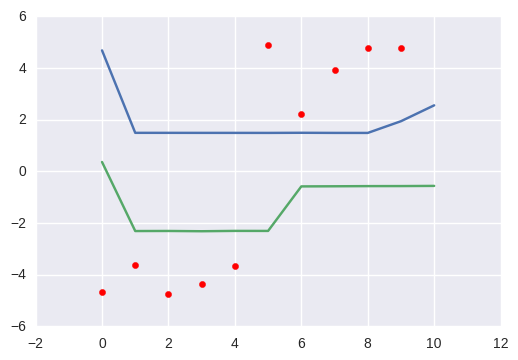

In [260]:
plotMBFS2(d,p0,p1,m0,m1)

## Particle Filter with discrete state and transition model

In [43]:
class BootstrapFilterDiscreteTransitionModel(object):
    
    def __init__(self, prior, tm, N=5000, noise = 0.1):

        self.tm = np.cumsum(tm, axis=1)
        
        #init particles
        #each particle has: state identifier, Mean, Var
        state = prior[0]
        n = N*state[-1]
        name = np.full((n), 0)
        mean = np.full((n), state[0])\
         + np.random.normal(scale=noise, size=n)
        var = np.full((n), state[1])\
         + np.random.normal(scale=noise, size=n)
        self.particles = np.stack((name,mean,var), axis=-1)
        
        for i, state in enumerate(prior[1:]):
            n = N*state[-1]
            name = np.full((n), i+1)
            mean = np.full((n), state[0])\
             + np.random.normal(scale=noise, size=n)
            var = np.full((n), state[1])\
             + np.random.normal(scale=noise, size=n)
            p = np.stack((name,mean,var), axis=-1)
            self.particles = np.concatenate((self.particles, p))
        print self.particles.shape
        
        
    def importantSampling(self, datum):
        
        for p in self.particles:
            self.markovTransition(p)
            #weightParticle
            #this needs to be saved in an array
            unWeightP = scipy.stats.norm(p[1], p[2]).pdf(datum)
        
        #normalise weights
        self.weights = normWeights(unWeights)
        
    def resample(self):
        #dont know yet
        pass
        
    def markovTransition(self, p):
        r = np.random.rand()
        newState = np.searchsorted(self.tm[p[0]], r)
        p[0] = newState
        #TODO update mean and var of particle to new state
        pass
        